# Auto Regressive (AR) Models

One of the fundamental linear predictive models in time-series forecastig is an auto-regressive model. \
A linear regression model fits a function $F$ with some inferable / trainable parameters $\theta$ on an independent variable $X$ to predict a response variable $Y$. 

$Y = F(X, \theta)$

For a linear regression model where the instance $x$ is a vector $(x_1, x_2)$ it often takes the form \
$y = c_0 + c_1 \times x_1 + c_2 \times x_2$ 
Where $x \epsilon X$, $Y \epsilon Y$, such that $X$ and $Y$ are disrtibutions and $\theta = \{c_0, c_1\}$

In an auto-regressive model the response variable $y_t$ at a time point $t$ depends on a combination of input variables 
from the same time series in the past - $(x_{t-1}, x_{t-2}, ..., x_{t-n})$

We can write an auto-regressive model as \
$y_t = c_0 + c_1 \times x_{t-1} + c_2 \times x_{t-2}$ 

In this notebook we will look at example of how define and train such AR model using python libraries.

## Notebook Setup

In [61]:
!pip install pandas numpy statsmodels scikit-learn

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Explore the dataset

In [10]:
data = pd.read_csv(open('datasets/daily-min-temperatures.csv', 'r'), header=0, index_col=0)

In [17]:
data.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


<Axes: xlabel='Date'>

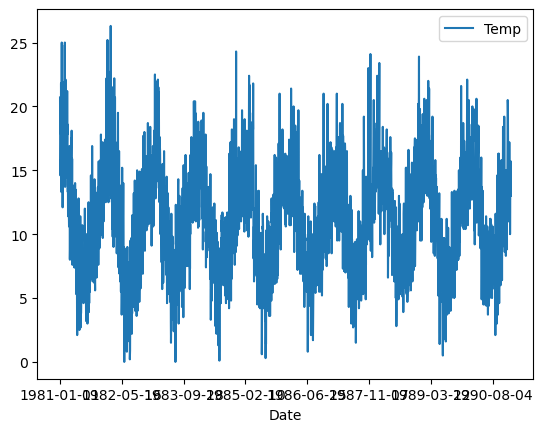

In [22]:
data.plot()

## Autocorrelation

In order for AR to work correctly there must be some correlation between $x_t$ and its previous points $x_t-1$. If a series is composed of pure noise, time-series forecasting methods cannot be used. We will use a function called as `lag_plot` to visually inspect the autocorrelation.

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

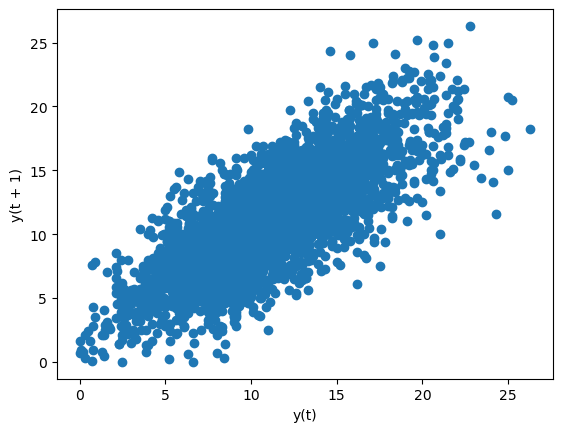

In [34]:
pd.plotting.lag_plot(data)

The narrow spread shows a good correlation. 

We can also adjust the lag parameter to see the relationship with values further back in time.

<Axes: xlabel='y(t)', ylabel='y(t + 2)'>

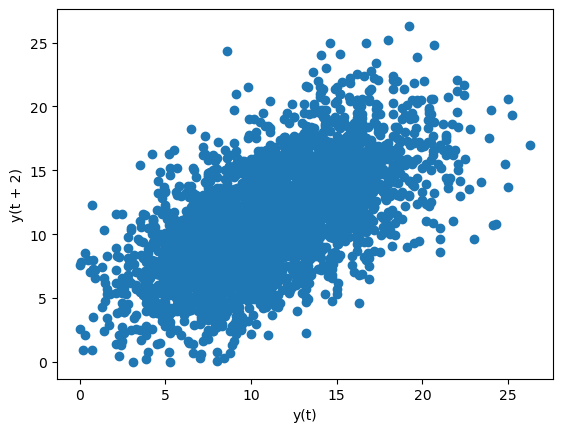

In [35]:
pd.plotting.lag_plot(data, 2)

With $lag=2$ we can already see the spreed is widenning. Going further back in time might not be beneficial.

<Axes: xlabel='y(t)', ylabel='y(t + 50)'>

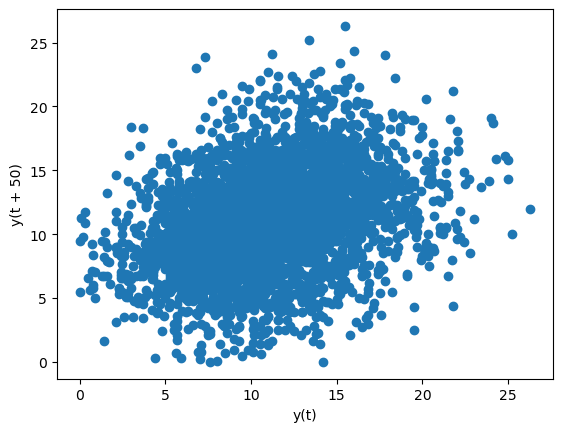

In [36]:
pd.plotting.lag_plot(data, 50)

50 time points back, it looks very terrible.

### Pearson Correlation
We can use Pearson Correlation coeffecient to see how corelated 2 variables are.

In [54]:
df = pd.concat([data, data.shift(1), data.shift(2), data.shift(3), data.shift(4), data.shift(5)], axis=1)
df.columns=[f"t-{x}" for x in range(0, 6)]
pc = df.corr()
print(pc)

          t-0       t-1       t-2       t-3       t-4       t-5
t-0  1.000000  0.774870  0.631119  0.586375  0.578898  0.578572
t-1  0.774870  1.000000  0.774886  0.631095  0.586346  0.578866
t-2  0.631119  0.774886  1.000000  0.774878  0.631051  0.586273
t-3  0.586375  0.631095  0.774878  1.000000  0.774857  0.631012
t-4  0.578898  0.586346  0.631051  0.774857  1.000000  0.774832
t-5  0.578572  0.578866  0.586273  0.631012  0.774832  1.000000


As the lag parameter increases our correlation coeffecient goes very quickly.

### Autocorrelation Plot

We can also visualize correlation coeffecient on a plot against the lag parameter.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

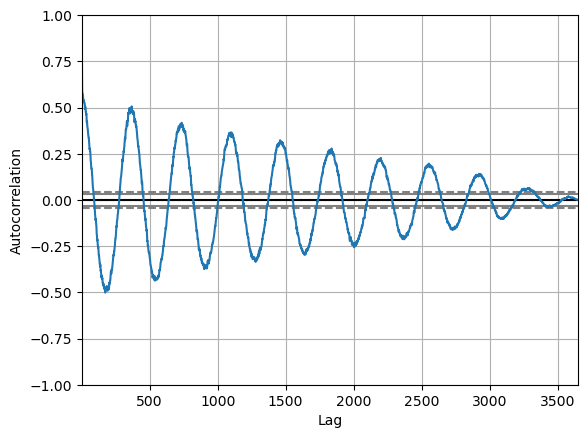

In [57]:
pd.plotting.autocorrelation_plot(data)

We can see co-effecients oscillate from positive correlation to negative, as the lag increases. This is expected as the series is periodic and oscillates. We can see the amplitude reduce with greater lag values, which tells us that older data points in the series are not very good indicators of the future values.

## Fitting a AR model

We can now fit an AR model to do prediction. 

In [63]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import math

predicted=11.871688, expected=12.900000
predicted=13.052959, expected=14.600000
predicted=13.532909, expected=14.000000
predicted=13.244517, expected=13.600000
predicted=13.091894, expected=13.500000
predicted=13.147498, expected=15.700000
predicted=13.177283, expected=13.000000
Test RMSE: 1.225


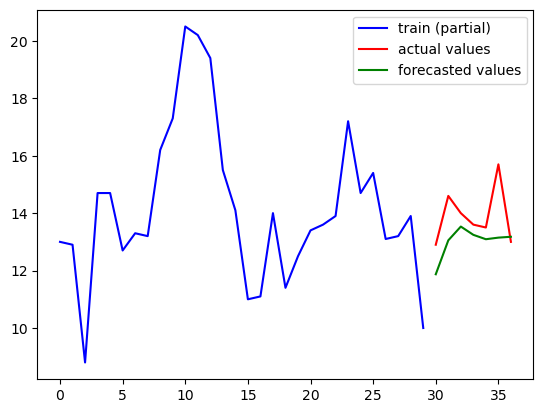

In [85]:
X = data.values
# We are going to test on the last 7 days and train on everything before that.
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
# We will include about 30 days of lags. So the output will depend on 30 days of data.
model = AutoReg(train, lags=30)
model_fit = model.fit()
#print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
 print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
xticks = range(0, 30+7)
plt.plot(xticks[:30],train[-30:], label='train (partial)', color='b')
plt.plot(xticks[30:37], test, label='actual values', color='r')
plt.plot(xticks[30:37], predictions, label='forecasted values', color='g')
plt.legend()

## Conclusion
It looks like the AR model did fairly well. It was able to predict the next 7 days of temperature with about +/1 1.2 days of error.